# Линейная регрессия: построение, оценка адекватности и тюнинг

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
df = individual_household_electric_power_consumption.data.features

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)


/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [ ]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


Описание переменных датасета Individual Household Electric Power Consumption

    Date:
        Дата измерения в формате дд/мм/гггг (например, 16/12/2006).

    Time:
        Время измерения в формате чч:мм:сс (например, 17:24:00)..

    Global_active_power:
        Суммарная активная мощность, потребляемая в доме.
        Единица измерения: киловатт (kW).

    Global_reactive_power:
        Суммарная реактивная мощность, потребляемая в доме.
        Единица измерения: киловатт (kW).

    Voltage:
        Напряжение сети в доме.
        Единица измерения: вольты (V).

    Global_intensity:
        Суммарная электрическая интенсивность.
        Единица измерения: амперы (A).

    Sub_metering_1:
        Потребляемая активная мощность в подгруппе 1 (кухня).
        Единица измерения: ватт-час (Wh).

    Sub_metering_2:
        Потребляемая активная мощность в подгруппе 2 (прачечная).
        Единица измерения: ватт-час (Wh).

    Sub_metering_3:
        Потребляемая активная мощность в подгруппе 3 (нагревательные приборы, кондиционеры).
        Единица измерения: ватт-час (Wh).


Основная цель: построить модель, которая анализирует временной ряд энергопотребления дома, используя предоставленные параметры, и предсказывает будущие значения активной мощности (Global_active_power) на основе факторов, таких как напряжение, интенсивность, и потребление в подгруппах.

# Предобработка

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [ ]:
# Объединение даты и времени
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Удаление исходных столбцов Date и Time
df.drop(columns=['Date', 'Time'], inplace=True)

# Установка временной метки как индекса
df.set_index('Datetime', inplace=True)


In [ ]:
# Преобразование столбцов к числовому формату
numeric_columns = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

# Преобразуем в числовой формат, заменяя некорректные значения на NaN
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Проверка наличия пропущенных значений после преобразования
print(df.isnull().sum())

# Заполнение пропущенных значений (например, медианой столбца)
df.fillna(df.median(), inplace=True)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.085486e+00,1.234176e-01,2.408420e+02,4.602375e+00,1.107879e+00,1.282265e+00,6.390116e+00
std,1.052065e+00,1.120452e-01,3.219699e+00,4.422241e+00,6.115669e+00,5.787271e+00,8.406114e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


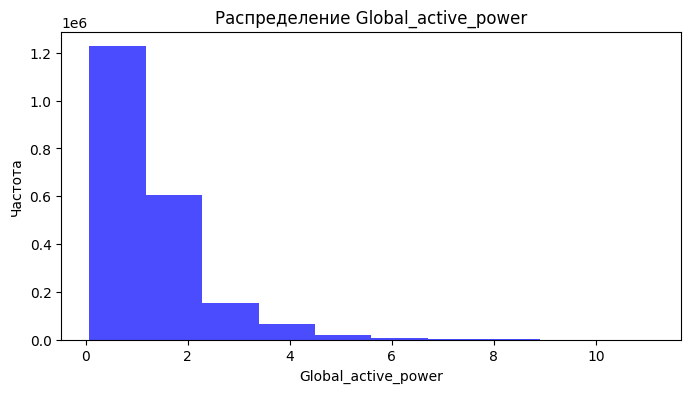

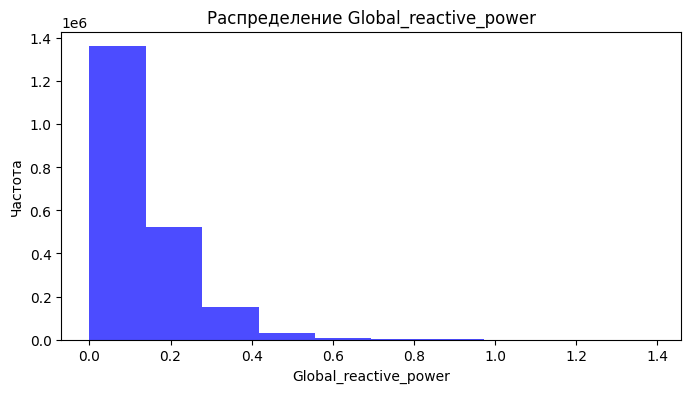

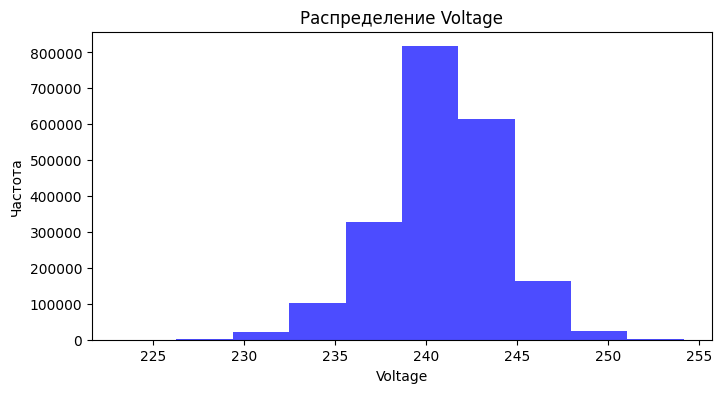

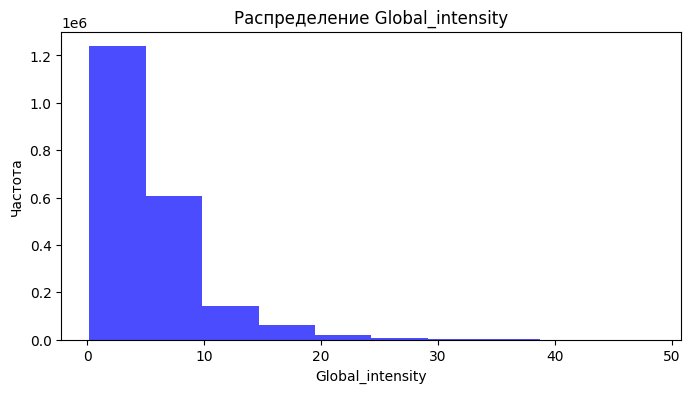

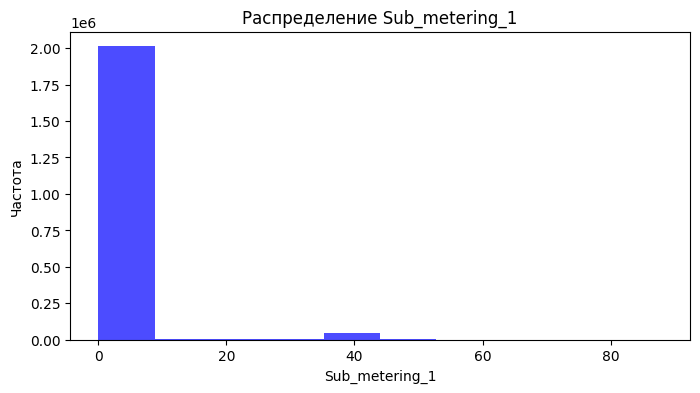

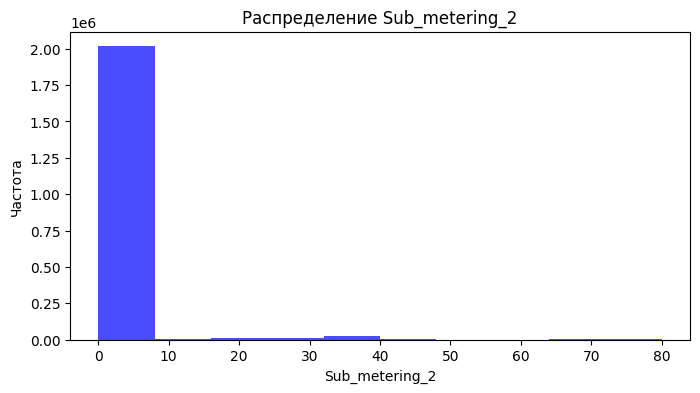

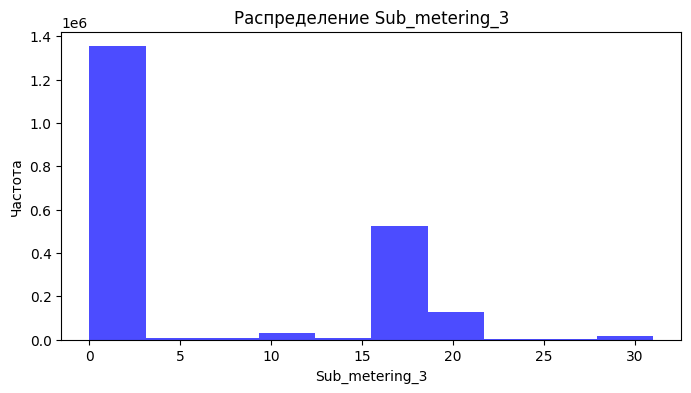

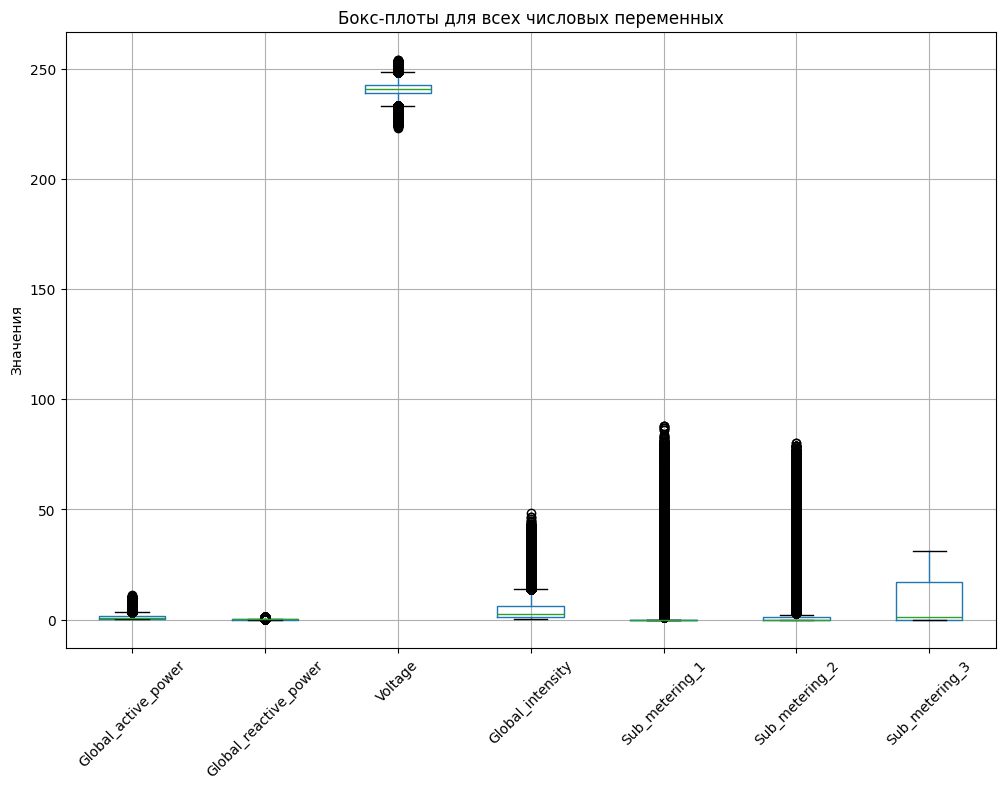

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Построение гистограмм для каждого столбца
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col], bins=10, color="blue", alpha=0.7)
    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.show()

# Построение бокс-плотов
plt.figure(figsize=(12, 8))
df[numeric_columns].boxplot()
plt.title("Бокс-плоты для всех числовых переменных")
plt.xticks(rotation=45)
plt.ylabel("Значения")
plt.show()


In [ ]:
# Удаляем колонку Sub_metering_1
df = df.drop(columns=['Sub_metering_1'], errors='ignore')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant

def preprocess_data(df):
    # Удаляем выбросы
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

df = preprocess_data(df)


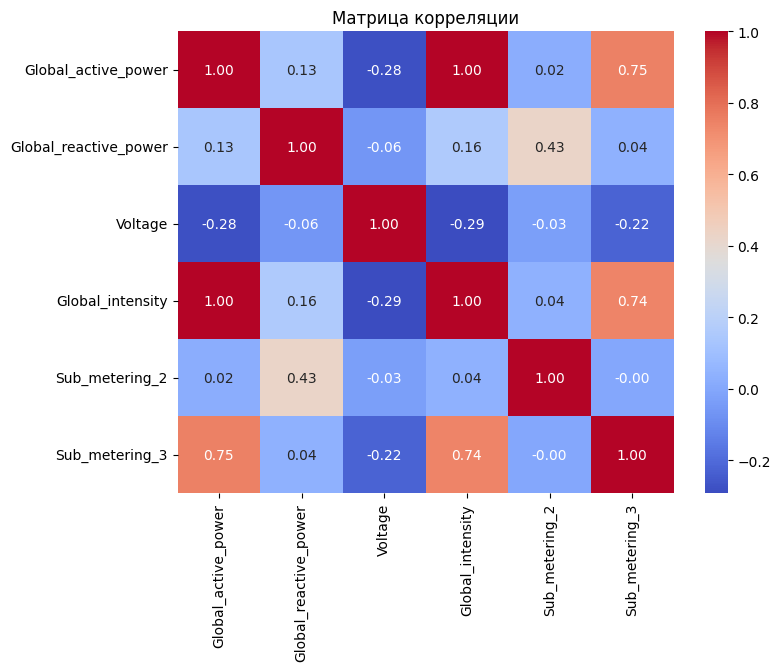

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Построение матрицы корреляции
correlation_matrix = df.corr()


# Визуализация матрицы корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляции")
plt.show()

# Модель

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant

# Разделение данных на train и test в порядке времени
def split_time_series(df, target_column, test_size=0.2):
    """
    Разделяет временной ряд на обучающую и тестовую выборки.
    :param df: DataFrame с данными
    :param target_column: Имя столбца целевой переменной
    :param test_size: Доля данных для тестовой выборки
    :return: X_train, X_test, y_train, y_test
    """
    split_index = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column]
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    print(f"Размер обучающей выборки: {len(X_train)}")
    print(f"Размер тестовой выборки: {len(X_test)}")

    return X_train, X_test, y_train, y_test

# Проверка корреляции между факторами
def check_multicollinearity(X, threshold):
    """
    Проверка корреляции между факторами.
    """
    corr_matrix = X.corr()
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    print("\nСильно коррелированные факторы:")
    for pair in correlated_pairs:
        print(f"{pair[0]} и {pair[1]} (корреляция: {corr_matrix.loc[pair[0], pair[1]]})")
    return correlated_pairs

# Проверка корреляции факторов с откликом
def check_correlation_with_response(X, y, threshold):
    """
    Проверка корреляции факторов с откликом.
    """
    correlations = X.corrwith(y)
    print("\nКорреляции факторов с откликом:")
    print(correlations)

    low_corr_factors = correlations[abs(correlations) < threshold].index.tolist()
    print(f"\nФакторы с низкой корреляцией с откликом (<{threshold}): {low_corr_factors}")
    return low_corr_factors

# Оценка модели
def evaluate_model(X, y):
    """
    Оценка модели: R^2, F-статистика, RMSE и средняя относительная ошибка.
    """
    X_const = add_constant(X)
    model = OLS(y, X_const).fit()
    y_pred = model.predict(X_const)

    r2 = model.rsquared
    f_stat = model.fvalue
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    e = np.mean(np.abs((y - y_pred) / y_pred))

    adequacy_message = "Модель адекватна" if r2 > 0.7 and model.f_pvalue < 0.05 else "Модель неадекватна"

    print("\nОценка модели:")
    print(f"R^2: {r2:.4f}, F-статистика: {f_stat:.4f}, RMSE: {rmse:.4f}, Средняя ошибка: {e:.4f}")
    print(adequacy_message)
    print(model.summary())

    return r2, f_stat, rmse, e, model, adequacy_message

# Интерактивный отбор факторов
def user_feature_selection(X, y, significance_level, corr_threshold, response_corr_threshold):
    """
    Процесс отбора факторов с участием пользователя.
    """
    remaining_features = X.columns.tolist()
    final_model = None
    while True:
        print("\nТекущие факторы:")
        print(remaining_features)

        print("\nТекущая модель:")
        r2, f_stat, rmse, e, final_model, adequacy_message = evaluate_model(X[remaining_features], y)

        correlated_pairs = check_multicollinearity(X[remaining_features], corr_threshold)
        low_corr_factors = check_correlation_with_response(X[remaining_features], y, response_corr_threshold)

        max_pval = final_model.pvalues[1:].max()
        if max_pval > significance_level:
            factor_to_remove = final_model.pvalues[1:].idxmax()
            print(f"\nФактор {factor_to_remove} имеет высокий p-value ({max_pval}). Рекомендуется удалить.")
        else:
            factor_to_remove = None

        user_input = input("Введите фактор для удаления (или нажмите Enter, чтобы завершить): ")
        if user_input == "":
            break

        if user_input in remaining_features:
            remaining_features.remove(user_input)
            print(f"Фактор {user_input} удален.")
        else:
            print(f"Фактор {user_input} не найден. Попробуйте снова.")

    print("\nИтоговая модель после отбора факторов:")
    evaluate_model(X[remaining_features], y)

    return remaining_features, final_model


# Главная функция
def main(df):
    # Предобработка данных
    df = preprocess_data(df)

    # Разделение данных
    X_train, X_test, y_train, y_test = split_time_series(df, target_column="Global_active_power")

    # Параметры отбора факторов
    significance_level = float(input("Введите уровень значимости (например, 0.05): "))
    corr_threshold = float(input("Введите порог корреляции между факторами (например, 0.8): "))
    response_corr_threshold = float(input("Введите порог корреляции с откликом (например, 0.3): "))

    # Отбор факторов на обучающей выборке
    print("\nНачинаем процесс отбора факторов:")
    final_features, final_model = user_feature_selection(X_train, y_train, significance_level, corr_threshold, response_corr_threshold)

    # Сохранение и возврат результатов
    return final_model, X_train, y_train, X_test, y_test, final_features

In [ ]:
# Выполнение основного процесса
final_model, X_train, y_train, X_test, y_test, final_features = main(df)

Размер обучающей выборки: 1445001
Размер тестовой выборки: 361251
Введите уровень значимости (например, 0.05): 0.05
Введите порог корреляции между факторами (например, 0.8): 0.8
Введите порог корреляции с откликом (например, 0.3): 0.3

Начинаем процесс отбора факторов:

Текущие факторы:
['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2', 'Sub_metering_3']

Текущая модель:

Оценка модели:
R^2: 0.9976, F-статистика: 120484529.8808, RMSE: 0.0349, Средняя ошибка: 0.0513
Модель адекватна
                             OLS Regression Results                            
Dep. Variable:     Global_active_power   R-squared:                       0.998
Model:                             OLS   Adj. R-squared:                  0.998
Method:                  Least Squares   F-statistic:                 1.205e+08
Date:                 Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                         10:04:16   Log-Likelihood:             2.7962e+06
No. Obser

<ipython-input-11-1b59e00b7b3a>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_df_agg = train_df.resample(agg_freq).mean()
<ipython-input-11-1b59e00b7b3a>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_df_agg = test_df.resample(agg_freq).mean()


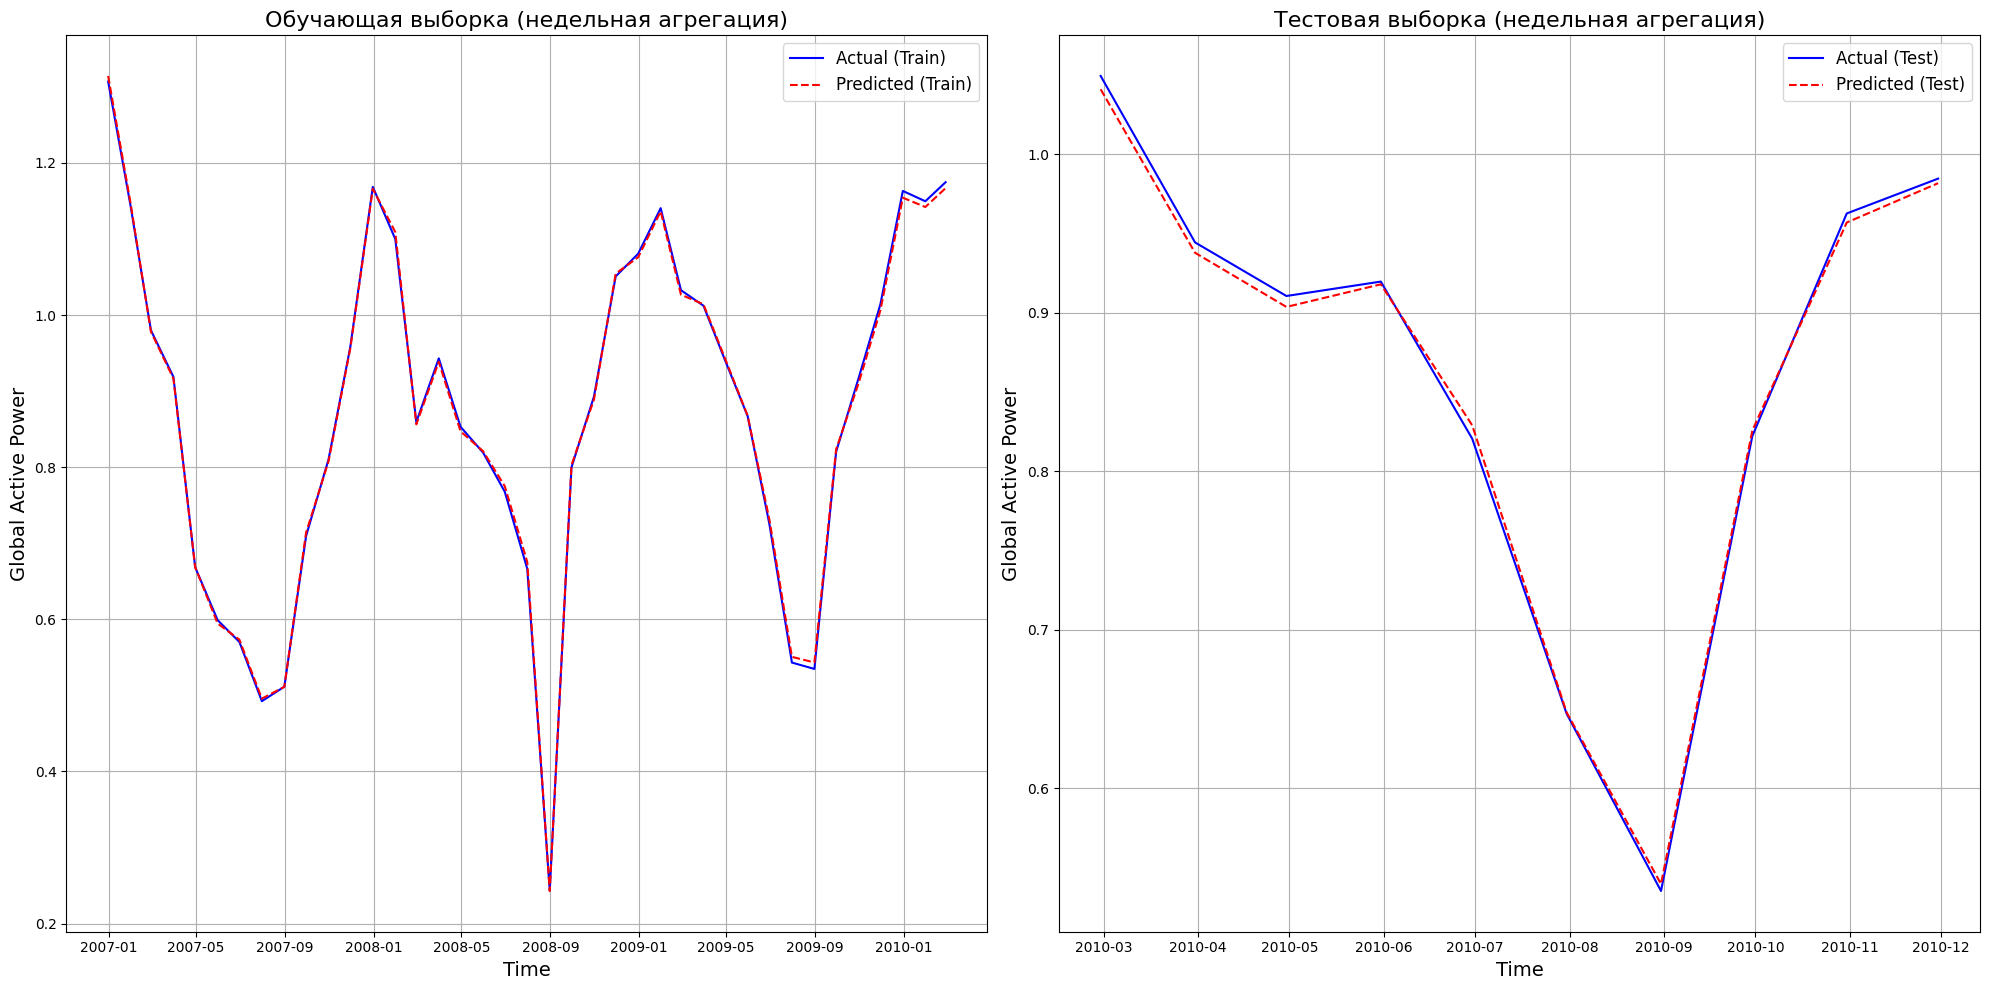

In [ ]:
def predict_and_plot(final_model, X_train, y_train, X_test, y_test, final_features, agg_freq='M'):
    """
    Выполняет предсказания и визуализирует результаты на обучающей и тестовой выборках с указанной агрегацией.
    """
    # Предсказания на обучающей выборке
    train_predictions = final_model.predict(add_constant(X_train[final_features]))

    # Предсказания на тестовой выборке
    test_predictions = final_model.predict(add_constant(X_test[final_features]))

    # Создание DataFrame для агрегации
    train_df = pd.DataFrame({'Actual': y_train, 'Predicted': train_predictions}, index=y_train.index)
    test_df = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions}, index=y_test.index)

    # Агрегация данных (недельная)
    train_df_agg = train_df.resample(agg_freq).mean()
    test_df_agg = test_df.resample(agg_freq).mean()

    # Визуализация
    plt.figure(figsize=(20, 10))  # Увеличенный размер графика

    # График для обучающей выборки
    plt.subplot(1, 2, 1)
    plt.plot(train_df_agg.index, train_df_agg['Actual'], label="Actual (Train)", color="blue")
    plt.plot(train_df_agg.index, train_df_agg['Predicted'], label="Predicted (Train)", color="red", linestyle="--")
    plt.title("Обучающая выборка (недельная агрегация)", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Global Active Power", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # График для тестовой выборки
    plt.subplot(1, 2, 2)
    plt.plot(test_df_agg.index, test_df_agg['Actual'], label="Actual (Test)", color="blue")
    plt.plot(test_df_agg.index, test_df_agg['Predicted'], label="Predicted (Test)", color="red", linestyle="--")
    plt.title("Тестовая выборка (недельная агрегация)", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Global Active Power", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

predict_and_plot(final_model, X_train, y_train, X_test, y_test, final_features, agg_freq='M')

# Тюнинг

<ipython-input-17-02838247e1c7>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_monthly = pd.concat([X_train[final_features], y_train], axis=1).resample('M').mean()
<ipython-input-17-02838247e1c7>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_monthly = pd.concat([X_test[final_features], y_test], axis=1).resample('M').mean()



Оценка модели на подвыборке (помесячная агрегация):
Лаги: 3
RMSE (подвыборка): 0.0022
Средняя ошибка (E, подвыборка): 0.0020
                             OLS Regression Results                            
Dep. Variable:     Global_active_power   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                     7157.
Date:                 Wed, 04 Dec 2024   Prob (F-statistic):           2.27e-21
Time:                         10:35:11   Log-Likelihood:                 135.90
No. Observations:                   29   AIC:                            -237.8
Df Residuals:                       12   BIC:                            -214.6
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|    

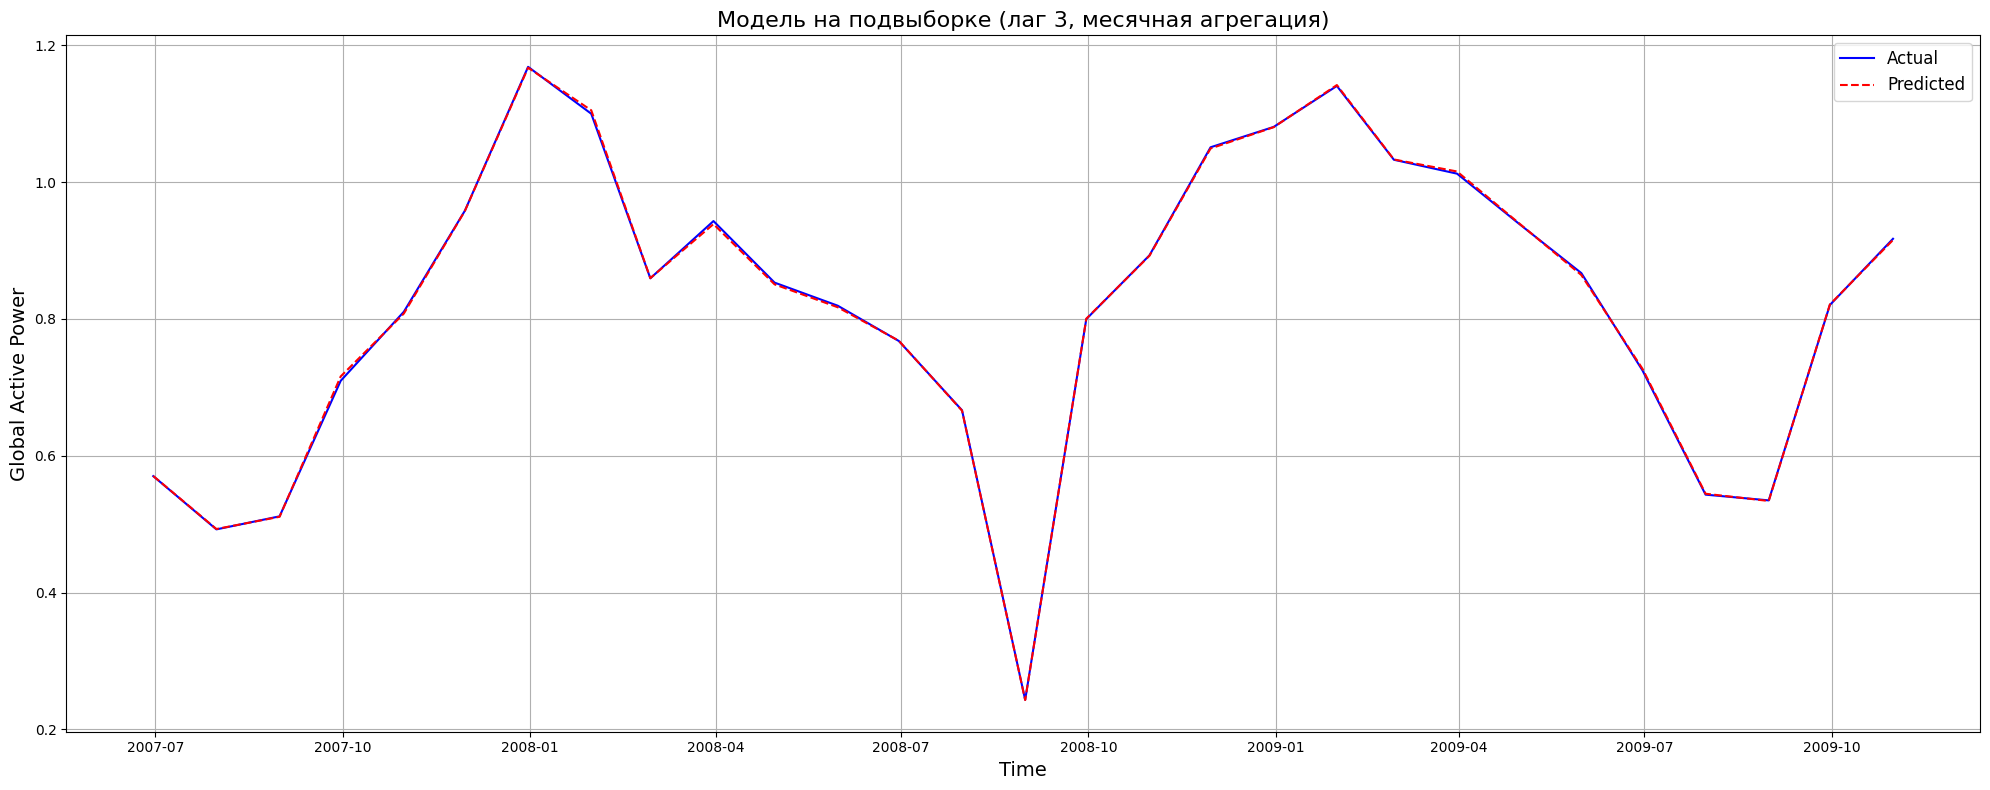

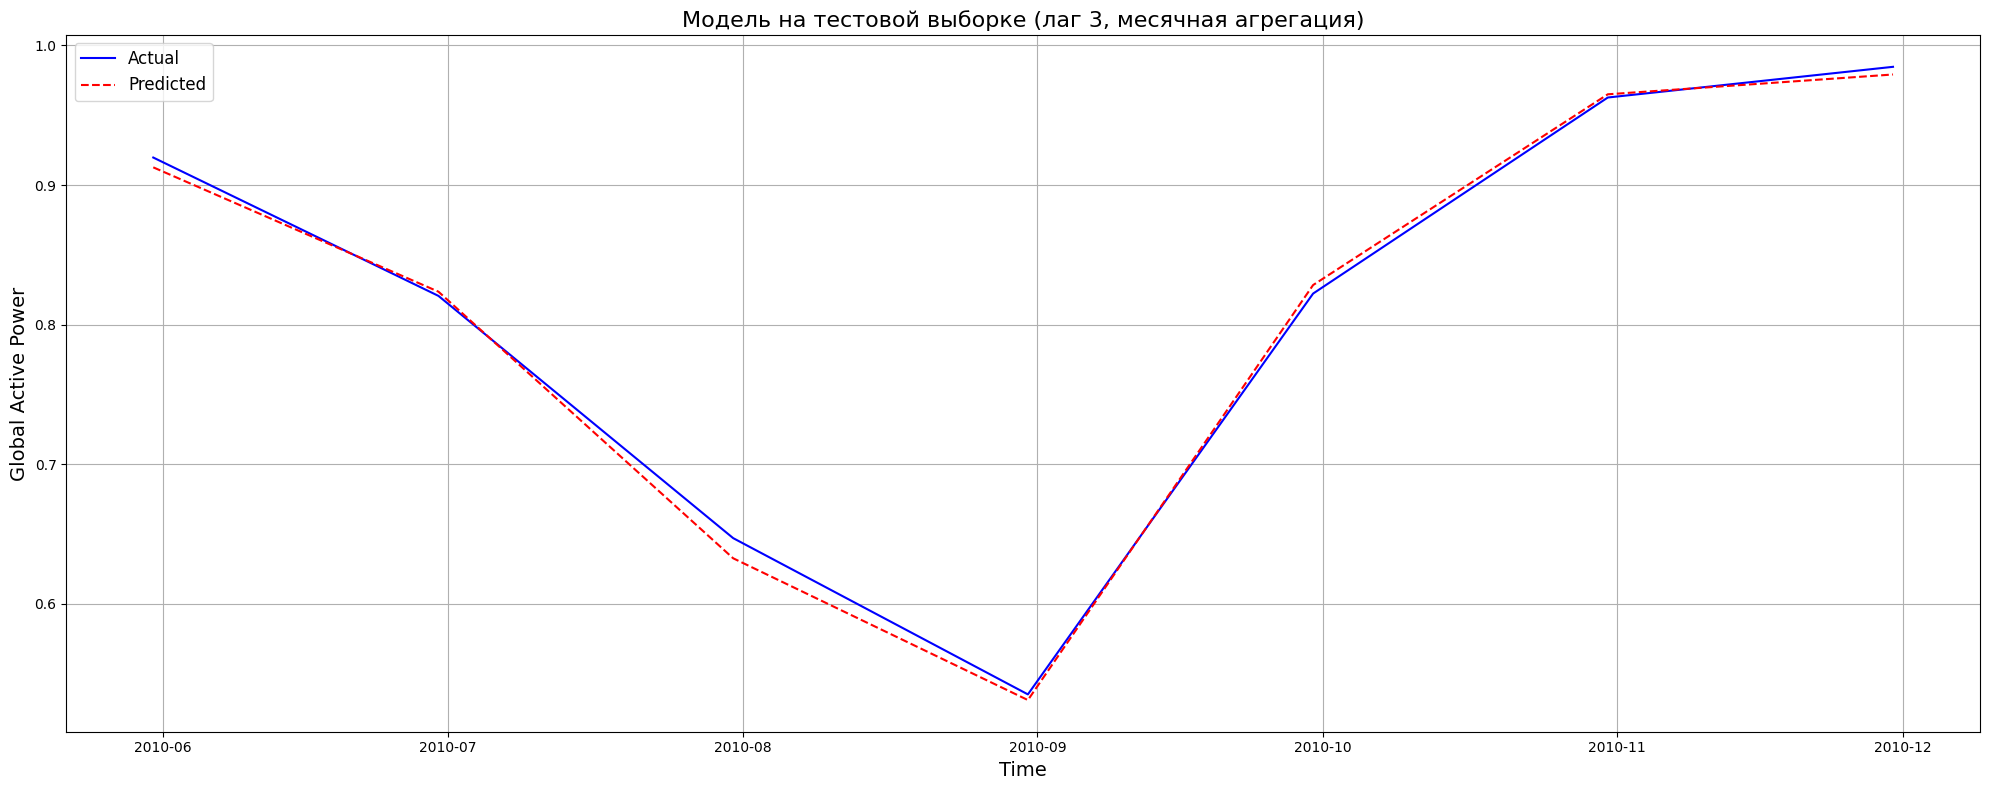

In [ ]:
def tune_model_with_monthly_aggregation(X_train, y_train, X_test, y_test, final_features, lags=1, subset_start=0.1, subset_end=0.9):
    """
    Тюнинг модели с использованием временных лагов, помесячной агрегацией и заданными признаками.
    """
    # Помесячная агрегация
    train_monthly = pd.concat([X_train[final_features], y_train], axis=1).resample('M').mean()
    test_monthly = pd.concat([X_test[final_features], y_test], axis=1).resample('M').mean()

    # Разделение данных на отклик и факторы
    y_train_monthly = train_monthly["Global_active_power"]
    X_train_monthly = train_monthly.drop(columns=["Global_active_power"])

    y_test_monthly = test_monthly["Global_active_power"]
    X_test_monthly = test_monthly.drop(columns=["Global_active_power"])

    # Добавление временных лагов только для отобранных признаков
    X_train_lagged = add_time_lags(X_train_monthly, lags)
    y_train_lagged = y_train_monthly[X_train_lagged.index]

    X_test_lagged = add_time_lags(X_test_monthly, lags)
    y_test_lagged = y_test_monthly[X_test_lagged.index]

    # Выделение подвыборки отклика (на обучающих данных)
    start_idx = int(len(y_train_lagged) * subset_start)
    end_idx = int(len(y_train_lagged) * subset_end)
    y_subset = y_train_lagged.iloc[start_idx:end_idx]
    X_subset = X_train_lagged.iloc[start_idx:end_idx]

    # Построение модели на подвыборке
    X_const = add_constant(X_subset)
    tuned_model = OLS(y_subset, X_const).fit()

    # Предсказания на подвыборке
    predictions_subset = tuned_model.predict(X_const)

    # Метрики на подвыборке
    rmse_subset = np.sqrt(mean_squared_error(y_subset, predictions_subset))
    e_subset = np.mean(np.abs((y_subset - predictions_subset) / predictions_subset))

    print("\nОценка модели на подвыборке (помесячная агрегация):")
    print(f"Лаги: {lags}")
    print(f"RMSE (подвыборка): {rmse_subset:.4f}")
    print(f"Средняя ошибка (E, подвыборка): {e_subset:.4f}")
    print(tuned_model.summary())

    # Предсказания на тестовой выборке
    X_const_test = add_constant(X_test_lagged)
    predictions_test = tuned_model.predict(X_const_test)

    # Метрики на тестовой выборке
    rmse_test = np.sqrt(mean_squared_error(y_test_lagged, predictions_test))
    e_test = np.mean(np.abs((y_test_lagged - predictions_test) / predictions_test))

    print("\nОценка модели на тестовой выборке (помесячная агрегация):")
    print(f"RMSE (тест): {rmse_test:.4f}")
    print(f"Средняя ошибка (E, тест): {e_test:.4f}")

    # Визуализация
    plot_lagged_predictions(y_subset, predictions_subset, title=f"Модель на подвыборке (лаг {lags}, месячная агрегация)")
    plot_lagged_predictions(y_test_lagged, predictions_test, title=f"Модель на тестовой выборке (лаг {lags}, месячная агрегация)")

    return tuned_model, rmse_subset, e_subset, rmse_test, e_test


def plot_lagged_predictions(y_actual, y_predicted, title):
    """
    Строит график фактических и предсказанных значений.
    :param y_actual: Фактические значения отклика.
    :param y_predicted: Предсказанные значения.
    :param title: Заголовок графика.
    """
    plt.figure(figsize=(20, 8))
    plt.plot(y_actual.index, y_actual, label="Actual", color="blue")
    plt.plot(y_actual.index, y_predicted, label="Predicted", color="red", linestyle="--")
    plt.title(title, fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Global Active Power", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Используем данные из предыдущей модели для тюнинга
tuned_model, tuned_rmse_subset, tuned_e_subset, tuned_rmse_test, tuned_e_test = tune_model_with_monthly_aggregation(
    X_train, y_train, X_test, y_test, final_features, lags=3, subset_start=0.1, subset_end=0.9
)
